In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import torch.nn as nn
import numpy as np
import torchvision
import torch
import torchvision.transforms as transforms
from tqdm.autonotebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import sys
sys.path.insert(1, '/scratch/gpfs/ls1546/mine/')
import mine

/tmp/ipykernel_3881766/4034527916.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [11]:
# params
run_name = 'cifar'
path = '/scratch/gpfs/ls1546/mine/'
dir = f'{path}data/'
# image_dim = args.image_dim
# num_neurons = args.num_neurons
batch_size = 50

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def scale_rgb(x):
    return (x - x.min()) / (x.max() - x.min())


In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))])

traindata = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch_size,
                                          shuffle=True, num_workers=8, pin_memory=True)

testdata = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                         shuffle=False, num_workers=8, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')


In [22]:
# create simple CNN to later get activations from (when trained)
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 channels, 6 output chs, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2) # 2x2 pooling
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 in chs, 16 out chs, 5x5 kernel
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dim except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = CNN().to(device)

# train model
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
losses = []

In [23]:
epochs = 175
for epoch in (pbar := tqdm(range(1, epochs + 1))):
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = net(images.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        pbar.set_description(f"epoch: {epoch}, loss: {loss.item():4f}")

  0%|          | 0/175 [00:00<?, ?it/s]

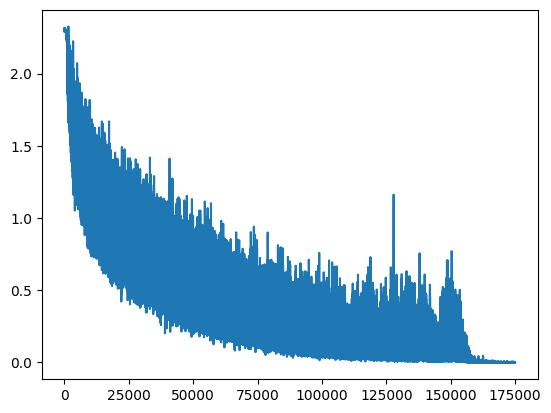

In [24]:
plt.plot(losses)

In [25]:
# save model
torch.save(net.state_dict(), f'{dir}{run_name}model.pth')

In [37]:
# add hooks, run model with inputs to get activations

# a dict to store the activations
activation = {}
def get_activation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach().cpu().numpy()
        # activation[name] = output.numpy()
    return hook

hookconv1 = net.conv1.register_forward_hook(get_activation('conv1'))
hookfc1 = net.fc1.register_forward_hook(get_activation('fc1'))
hookfc3 = net.fc3.register_forward_hook(get_activation('fc3'))

inputs_list = []
outputs_list = []
act_list_conv1 = []
act_list_l1 = []
act_list_l3 = []

# pass images through CNN to get activations
for inputs, _ in tqdm(testloader):
    with torch.no_grad():
        outputs = net(inputs.to(device))
        
        # collect the activations
        act_list_conv1.append(activation['conv1'])
        act_list_l1.append(activation['fc1'])
        act_list_l3.append(activation['fc3'])

        inputs_list.append(inputs.detach().cpu().numpy())
        outputs_list.append(outputs.detach().cpu().numpy())

    del inputs
    del outputs

# detach the hooks
hookconv1.remove()
hookfc1.remove()
hookfc3.remove()

AttributeError: '_IncompatibleKeys' object has no attribute 'conv1'

In [13]:
image_size = 32

In [53]:

def flatten_activations(act_list):
    act_length = (len(act_list) - 1)*batch_size + len(act_list[len(act_list)-1])
    act_flat = np.zeros((act_length, np.prod(act_list[0].shape[1:])))
    for batch in range(len(act_list)):
        for image in range(len(act_list[batch])):
            act_flat[batch*len(act_list[0])+image, :] = act_list[batch][image].flatten()
    return act_flat

In [69]:
act_conv1 = flatten_activations(act_list_conv1)
act_l1 = flatten_activations(act_list_l1)
act_l3 = flatten_activations(act_list_l3)
images_flat = flatten_activations(inputs_list)
outputs_flat = flatten_activations(outputs_list)

In [87]:
del inputs_list, outputs_list, act_list_conv1, act_list_l1, act_list_l3

NameError: name 'inputs_list' is not defined

In [88]:

np.save(f'{dir}{run_name}_images.npy', images_flat)
np.save(f'{dir}{run_name}_act_conv1.npy', act_conv1)
np.save(f'{dir}{run_name}_act_l1.npy', act_l1)
np.save(f'{dir}{run_name}_act_l3.npy', act_l3)
np.save(f'{dir}{run_name}_outputs.npy', outputs_flat)

In [18]:
# load data
images_flat = np.load(f'{path}cifar_images.npy')
act_conv1 = np.load(f'{path}cifar_act_conv1.npy')
act_l1 = np.load(f'{path}cifar_act_l1.npy')
act_l3 = np.load(f'{path}cifar_act_l3.npy')
outputs_flat = np.load(f'{path}cifar_outputs.npy')

In [21]:
# params
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
neurons = np.arange(1, 10)
# for AdamW
lams = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

run = "cifar"
epochs = 350

x_dim=image_size*image_size*3
y_dim=act_conv1.shape[1]

batch_size = 500

def scale_rgb(x):
    return (x - x.min()) / (x.max() - x.min())

# split the responses and images into a train, val, and test set
train_samples = int(.8*len(images_flat))
val_samples = int(.1*len(images_flat))

images_flat_train = images_flat[:train_samples]
act_conv1_train = act_conv1[:train_samples]

images_flat_val = images_flat[train_samples:train_samples+val_samples]
act_conv1_val = act_conv1[train_samples:train_samples+val_samples]

images_flat_test = images_flat[train_samples+val_samples:]
act_conv1_test = act_conv1[train_samples+val_samples:]

for l in range(len(lams)):
    lam = lams[l]
    for i in neurons:
        class Image_network(nn.Module):
            def __init__(self, x_dim, y_dim):
                super().__init__()
                self.fc1x = nn.Linear(x_dim, i, bias=False)
                self.fc1y = nn.Linear(y_dim, 1, bias=True)
                self.fc2 = nn.Linear((i+1), 100, bias=True)
                self.fc3 = nn.Linear(100, 1, bias=True)

            def forward(self, x, y):
                x = F.relu(self.fc1x(x))
                y = F.relu(self.fc1y(y))
                h = torch.cat((x, y), dim=1)
                h = F.relu(self.fc2(h))
                h = self.fc3(h)
                return h

        model = mine.Mine(
            T=Image_network(x_dim, y_dim),
            loss="mine",  # mine_biased, fdiv
            device=device).to(device)

        run_name = f"{run}_{neurons[i-1]}_{lam}"

        img = torch.tensor(images_flat_train, dtype=torch.float32)
        act = torch.tensor(act_conv1_train, dtype=torch.float32)
        img_val = torch.tensor(images_flat_val, dtype=torch.float32)
        act_val =torch.tensor(act_conv1_val, dtype=torch.float32)

        mi, loss_list, loss_type = model.optimize(img, act, epochs, 
                                                  batch_size, lam, run_name, 
                                                  img_val, act_val)

        torch.save(model.T, f"{dir}{run_name}_mine.pth")
        np.save(f"{dir}{run_name}_mi.npy", mi.detach().cpu().numpy())
        np.save(f"{dir}{run_name}_loss.npy", loss_list)
        np.save(f"{dir}{run_name}_loss_type.npy", loss_type)

        plt.figure()
        plt.plot(loss_list)
        plt.title(f"loss: {run_name}, {epochs} epochs")
        plt.ylabel("loss")
        plt.xlabel("batches")
        plt.savefig(f"{run_name}_loss.pdf")

        plt.figure()
        plt.plot(loss_type)
        plt.title(f"loss type: {run_name}, {epochs} epochs")
        plt.ylabel("loss type (0=mine_biased, 1=mine)")
        plt.xlabel("batches")
        plt.savefig(f"{run_name}_loss_type.pdf")

        Tweights = model.T.fc1x.weight.detach().cpu().numpy()
        np.save(f'{dir}{run_name}_Tweights.npy', Tweights)

epoch: 350, mu_mi: 50.250529: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [01:45<00:00,  3.31it/s]


Final MI on test data: 3.1235086917877197


epoch: 350, mu_mi: 47.579451: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [01:47<00:00,  3.25it/s]


Final MI on test data: 2.5733072757720947


epoch: 350, mu_mi: 48.685870: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [01:44<00:00,  3.36it/s]


Final MI on test data: 3.033618927001953


epoch: 350, mu_mi: 47.712606: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [01:40<00:00,  3.47it/s]


Final MI on test data: 2.798860549926758


epoch: 350, mu_mi: 46.912964: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [01:43<00:00,  3.39it/s]


Final MI on test data: 2.904780149459839


epoch: 350, mu_mi: 44.308739: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [01:46<00:00,  3.30it/s]


Final MI on test data: 3.0669479370117188


epoch: 350, mu_mi: 46.458622: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [01:47<00:00,  3.26it/s]


Final MI on test data: 3.1806893348693848


epoch: 350, mu_mi: 46.130927: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [01:45<00:00,  3.31it/s]


Final MI on test data: 3.1716654300689697


epoch: 350, mu_mi: 47.077845: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [01:46<00:00,  3.29it/s]


Final MI on test data: 3.1697590351104736


epoch: 350, mu_mi: 46.100199: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [01:48<00:00,  3.24it/s]


Final MI on test data: 2.991478681564331


epoch: 350, mu_mi: 47.723043: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [01:46<00:00,  3.29it/s]


Final MI on test data: 3.0695338249206543


/tmp/ipykernel_3881766/2375758310.py:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
epoch: 350, mu_mi: 46.367480: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [01:47<00:00,  3.26it/s]


Final MI on test data: 3.005561590194702


epoch: 350, mu_mi: 46.447672: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [01:49<00:00,  3.19it/s]


Final MI on test data: 2.7935125827789307


epoch: 350, mu_mi: 46.438848: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [01:48<00:00,  3.24it/s]


Final MI on test data: 3.086522102355957


epoch: 350, mu_mi: 48.291515: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [01:47<00:00,  3.25it/s]


Final MI on test data: 2.8730688095092773


epoch: 350, mu_mi: 47.555136: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [01:48<00:00,  3.24it/s]


Final MI on test data: 3.057253837585449


epoch: 350, mu_mi: 48.505399: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [01:48<00:00,  3.23it/s]


Final MI on test data: 3.115467071533203


  0%|                                                                                                                                      | 0/350 [00:00<?, ?it/s]

In [26]:
plt.close('all')
final_mi_conv1 = []
for l in range(len(lams)):
    temp = []
    for i in range(1, 10):
        temp.append(np.load(f'{dir}cifar_{i}_{lams[l]}_mi.npy')[0])
    final_mi_conv1.append(temp)
final_mi_conv1 = np.array(final_mi_conv1)
final_mi_conv1.shape

(7, 9)

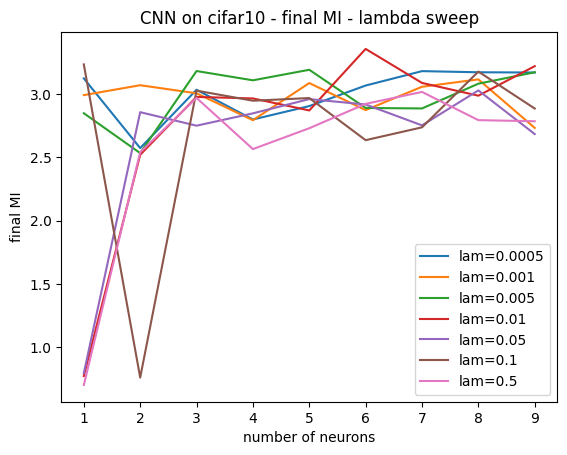

In [27]:
for l in range(len(lams)):
    plt.plot(np.arange(1, 10), final_mi_conv1[l], label=f'lam={lams[l]}')
plt.ylabel('final MI')
plt.xlabel('number of neurons')
plt.title('CNN on cifar10 - final MI - lambda sweep')
plt.legend()

  0%|          | 0/250 [00:00<?, ?it/s]

Final MI on test data: tensor([0.7005], device='cuda:0')


  0%|          | 0/250 [00:00<?, ?it/s]

Final MI on test data: tensor([0.8918], device='cuda:0')


  0%|          | 0/250 [00:00<?, ?it/s]

Final MI on test data: tensor([0.6820], device='cuda:0')


  0%|          | 0/250 [00:00<?, ?it/s]

Final MI on test data: tensor([1.0465], device='cuda:0')


  0%|          | 0/250 [00:00<?, ?it/s]

Final MI on test data: tensor([0.9179], device='cuda:0')


  0%|          | 0/250 [00:00<?, ?it/s]

Final MI on test data: tensor([0.9802], device='cuda:0')


  0%|          | 0/250 [00:00<?, ?it/s]

Final MI on test data: tensor([1.0307], device='cuda:0')


/tmp/ipykernel_2727041/3483479263.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


  0%|          | 0/250 [00:00<?, ?it/s]

Final MI on test data: tensor([1.0854], device='cuda:0')


  0%|          | 0/250 [00:00<?, ?it/s]

Final MI on test data: tensor([0.9505], device='cuda:0')


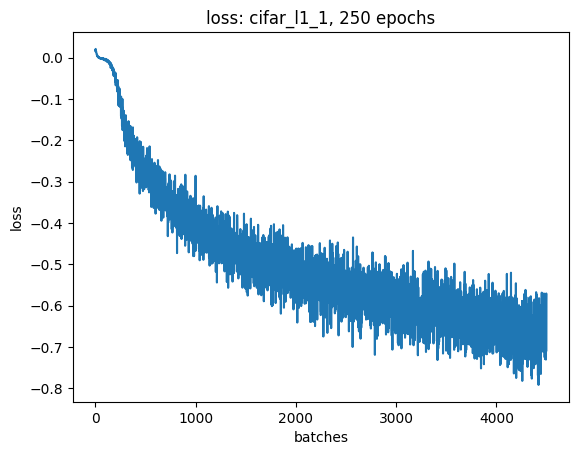

<Figure size 640x480 with 0 Axes>

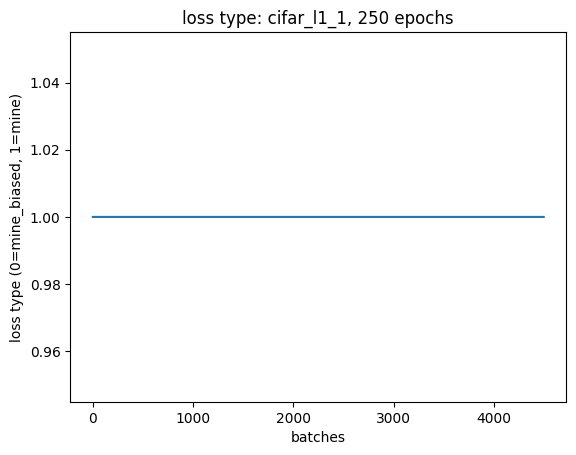

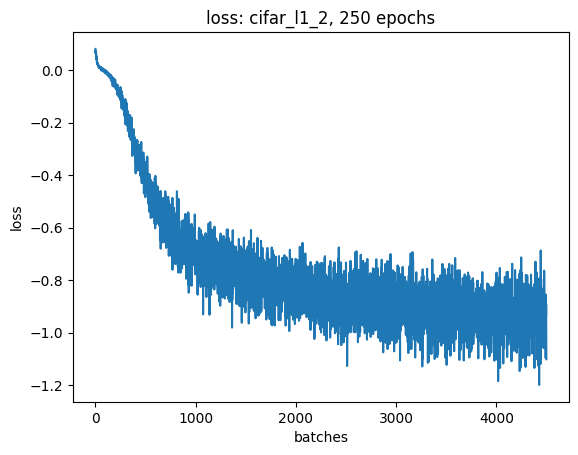

<Figure size 640x480 with 0 Axes>

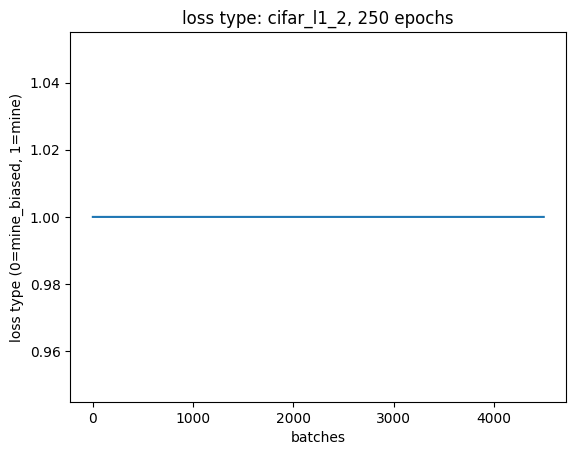

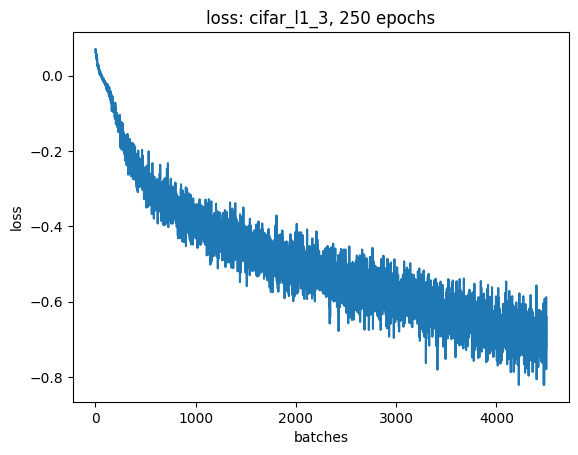

<Figure size 640x480 with 0 Axes>

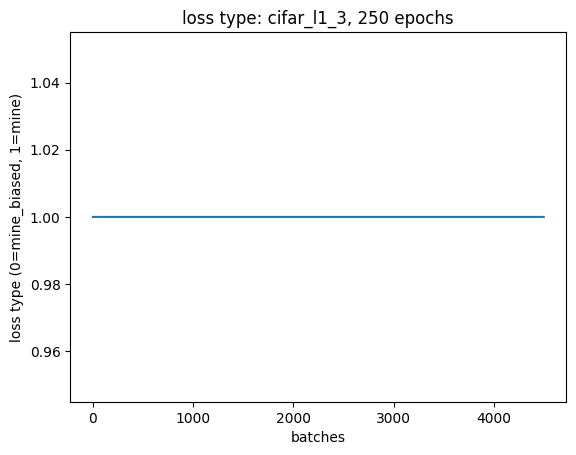

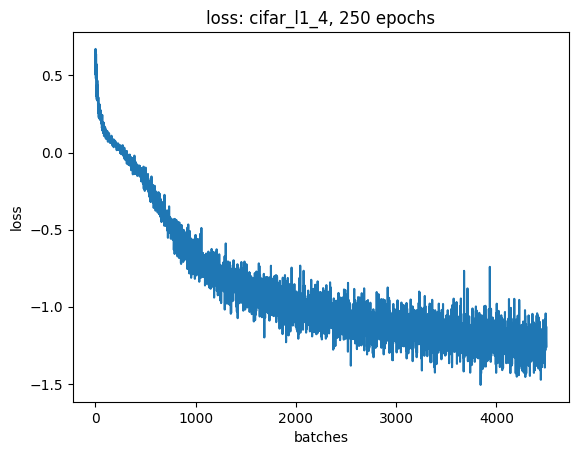

<Figure size 640x480 with 0 Axes>

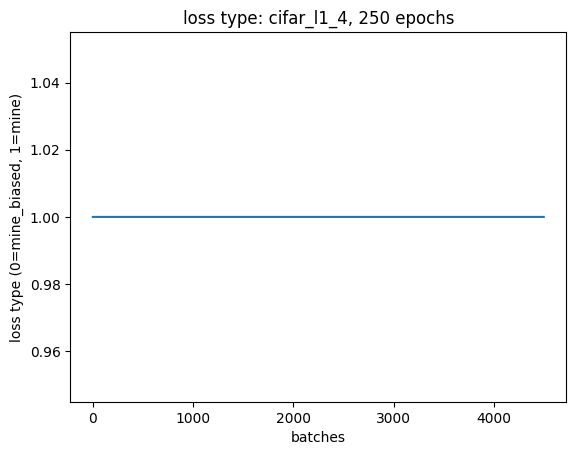

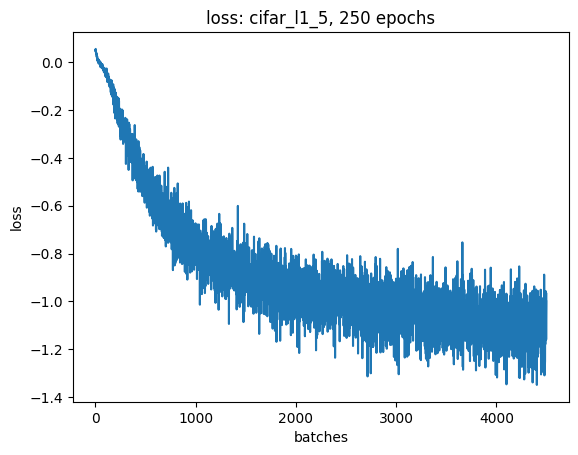

<Figure size 640x480 with 0 Axes>

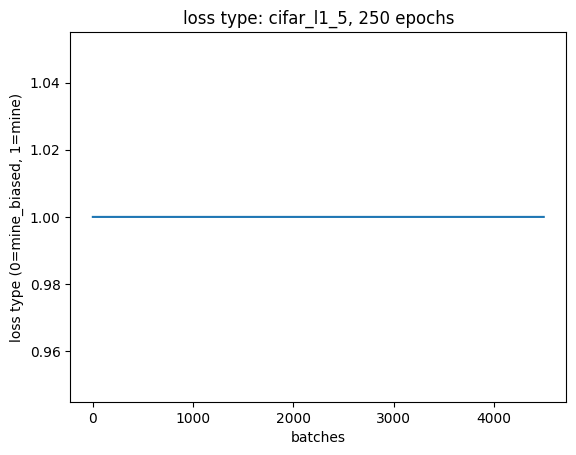

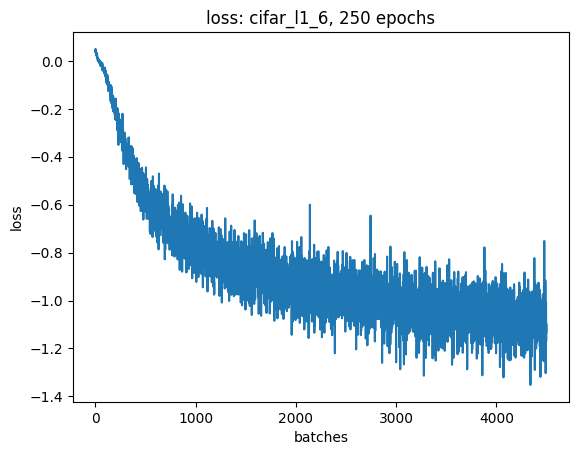

<Figure size 640x480 with 0 Axes>

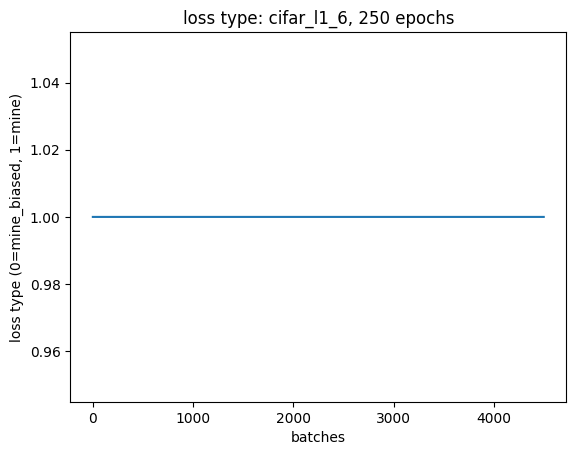

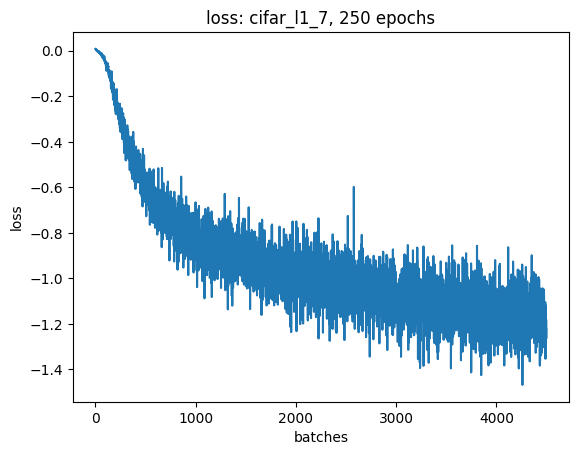

<Figure size 640x480 with 0 Axes>

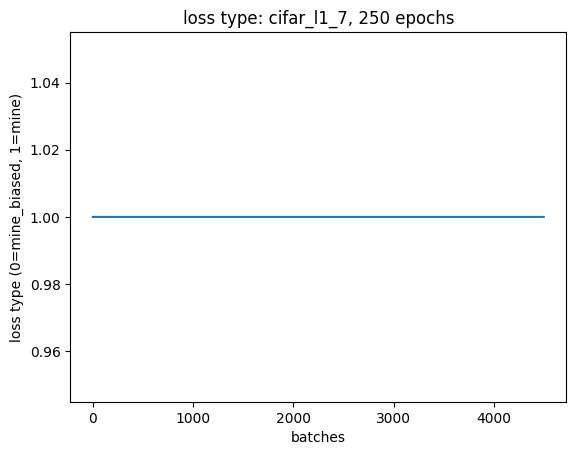

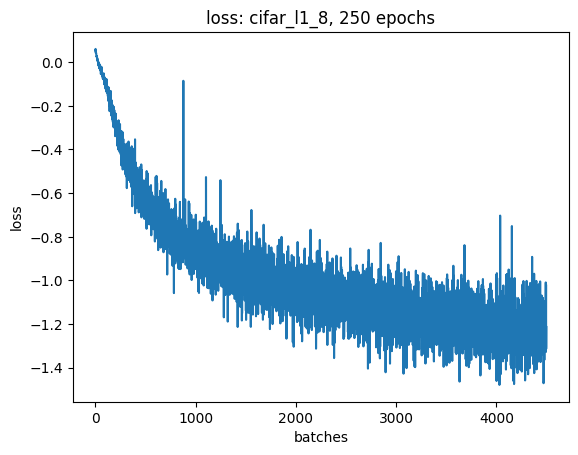

<Figure size 640x480 with 0 Axes>

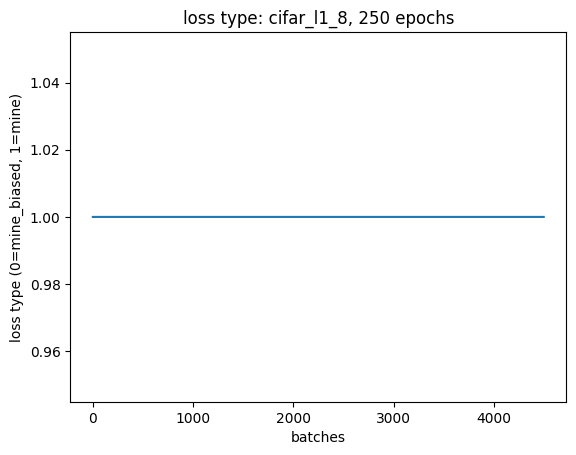

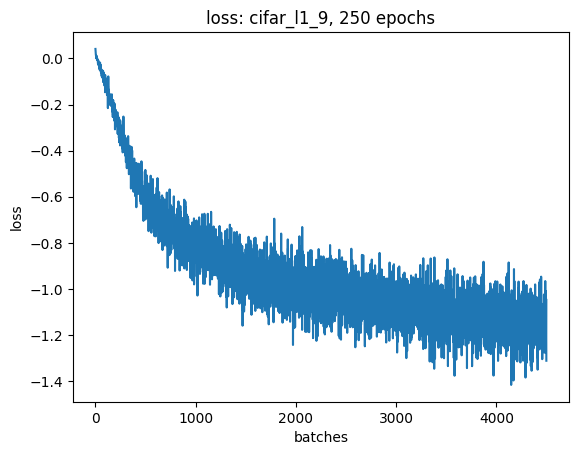

<Figure size 640x480 with 0 Axes>

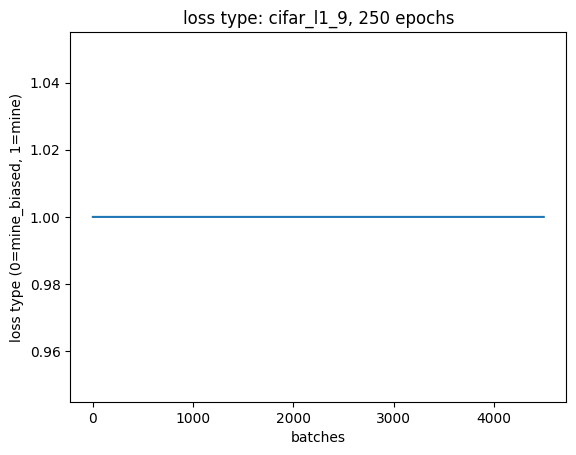

In [98]:
plt.close('all')
# params
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
neurons = np.arange(1, 10)
# for AdamW
lam = 0.005

run = "cifar_l1"
epochs = 250

x_dim=image_size*image_size*3
y_dim=act_l1.shape[1]

batch_size = 500

def scale_rgb(x):
    return (x - x.min()) / (x.max() - x.min())

# split the responses and images into a train and test set
train_samples = int(.9*len(images_flat))

images_flat_train = images_flat[:train_samples]
act_l1_train = act_l1[:train_samples]

images_flat_test = images_flat[train_samples:]
act_l1_test = act_l1[train_samples:]

for i in neurons:
    class Image_network(nn.Module):
        def __init__(self, x_dim, y_dim):
            super().__init__()
            self.fc1x = nn.Linear(x_dim, i, bias=False)
            self.fc1y = nn.Linear(y_dim, 1, bias=True)
            self.fc2 = nn.Linear((i+1), 100, bias=True)
            self.fc3 = nn.Linear(100, 1, bias=True)

        def forward(self, x, y):
            x = F.relu(self.fc1x(x))
            y = F.relu(self.fc1y(y))
            h = torch.cat((x, y), dim=1)
            h = F.relu(self.fc2(h))
            h = self.fc3(h)
            return h

    model = mine.Mine(
        T=Image_network(x_dim, y_dim),
        loss="mine",  # mine_biased, fdiv
        device=device).to(device)

    run_name = f"{run}_{neurons[i-1]}"
    mi, loss_list, loss_type = model.optimize(torch.tensor(images_flat_train, dtype=torch.float32), 
                                              torch.tensor(act_l1_train, dtype=torch.float32), epochs, batch_size, lam, run_name, 
                                              torch.tensor(images_flat_test, dtype=torch.float32), torch.tensor(act_l1_test, dtype=torch.float32))

    torch.save(model.T, f"{run_name}_mine.pth")
    np.save(f"{run_name}_mi.npy", mi.detach().cpu().numpy())
    np.save(f"{run_name}_loss.npy", loss_list)
    np.save(f"{run_name}_loss_type.npy", loss_type)

    plt.figure()
    plt.plot(loss_list)
    plt.title(f"loss: {run_name}, {epochs} epochs")
    plt.ylabel("loss")
    plt.xlabel("batches")
    plt.savefig(f"{run_name}_loss.pdf")

    plt.figure()
    plt.figure()
    plt.plot(loss_type)
    plt.title(f"loss type: {run_name}, {epochs} epochs")
    plt.ylabel("loss type (0=mine_biased, 1=mine)")
    plt.xlabel("batches")
    plt.savefig(f"{run_name}_loss_type.pdf")

    Tweights = model.T.fc1x.weight.detach().cpu().numpy()
    np.save(f'{run_name}_Tweights.npy', Tweights)

In [99]:
# params
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
neurons = np.arange(1, 10)
# for AdamW
lam = 0.005

run = "cifar_l3"
epochs = 250

x_dim=image_size*image_size*3
y_dim=act_l3.shape[1]

batch_size = 500

def scale_rgb(x):
    return (x - x.min()) / (x.max() - x.min())

# split the responses and images into a train and test set
train_samples = int(.9*len(images_flat))

images_flat_train = images_flat[:train_samples]
act_l3_train = act_l3[:train_samples]

images_flat_test = images_flat[train_samples:]
act_l3_test = act_l3[train_samples:]

for i in neurons:
    class Image_network(nn.Module):
        def __init__(self, x_dim, y_dim):
            super().__init__()
            self.fc1x = nn.Linear(x_dim, i, bias=False)
            self.fc1y = nn.Linear(y_dim, 1, bias=True)
            self.fc2 = nn.Linear((i+1), 100, bias=True)
            self.fc3 = nn.Linear(100, 1, bias=True)

        def forward(self, x, y):
            x = F.relu(self.fc1x(x))
            y = F.relu(self.fc1y(y))
            h = torch.cat((x, y), dim=1)
            h = F.relu(self.fc2(h))
            h = self.fc3(h)
            return h

    model = mine.Mine(
        T=Image_network(x_dim, y_dim),
        loss="mine",  # mine_biased, fdiv
        device=device).to(device)

    run_name = f"{run}_{neurons[i-1]}"
    mi, loss_list, loss_type = model.optimize(torch.tensor(images_flat_train, dtype=torch.float32), 
                                              torch.tensor(act_l3_train, dtype=torch.float32), epochs, batch_size, lam, run_name, 
                                              torch.tensor(images_flat_test, dtype=torch.float32), torch.tensor(act_l3_test, dtype=torch.float32))

    torch.save(model.T, f"{run_name}_mine.pth")
    np.save(f"{run_name}_mi.npy", mi.detach().cpu().numpy())
    np.save(f"{run_name}_loss.npy", loss_list)
    np.save(f"{run_name}_loss_type.npy", loss_type)

    plt.figure()
    plt.plot(loss_list)
    plt.title(f"loss: {run_name}, {epochs} epochs")
    plt.ylabel("loss")
    plt.xlabel("batches")
    plt.savefig(f"{run_name}_loss.pdf")

    plt.figure()
    plt.figure()
    plt.plot(loss_type)
    plt.title(f"loss type: {run_name}, {epochs} epochs")
    plt.ylabel("loss type (0=mine_biased, 1=mine)")
    plt.xlabel("batches")
    plt.savefig(f"{run_name}_loss_type.pdf")

    Tweights = model.T.fc1x.weight.detach().cpu().numpy()
    np.save(f'{run_name}_Tweights.npy', Tweights)

  0%|          | 0/250 [00:00<?, ?it/s]

Final MI on test data: tensor([0.2697], device='cuda:0')


  0%|          | 0/250 [00:00<?, ?it/s]

Final MI on test data: tensor([0.2686], device='cuda:0')


  0%|          | 0/250 [00:00<?, ?it/s]

Final MI on test data: tensor([0.2933], device='cuda:0')


  0%|          | 0/250 [00:00<?, ?it/s]

Final MI on test data: tensor([0.3660], device='cuda:0')


  0%|          | 0/250 [00:00<?, ?it/s]

In [102]:
final_mi_conv1 = np.empty(9)
final_mi_l1 = np.empty(9)
final_mi_l3 = np.empty(9)

for i in range(1, 10):
    final_mi_conv1[i-1] = np.load(f'{dir}cifar_{i}_mi.npy')[0]
    final_mi_l1[i-1] = np.load(f'{dir}cifar_l1_{i}_mi.npy')[0]
    final_mi_l3[i-1] = np.load(f'{dir}cifar_l3_{i}_mi.npy')[0]

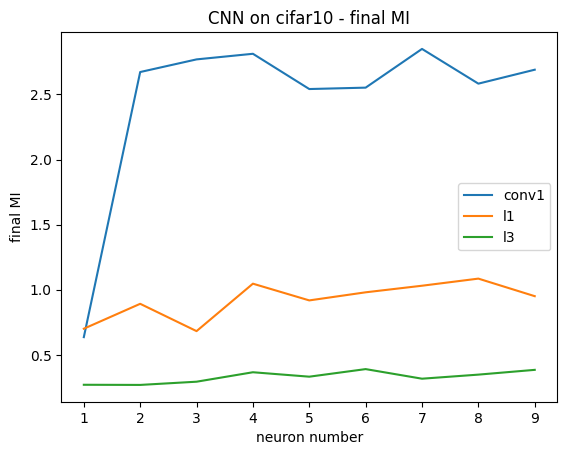

In [104]:
plt.plot(np.arange(1, 10), final_mi_conv1, label='conv1')
plt.plot(np.arange(1, 10), final_mi_l1, label='l1')
plt.plot(np.arange(1, 10), final_mi_l3, label='l3')
plt.ylabel('final MI')
plt.xlabel('neuron number')
plt.title('CNN on cifar10 - final MI')
plt.legend()